In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision import models
import rasterio
from sklearn.cluster import KMeans



In [2]:
# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained segmentation model (e.g., DeepLabV3)
model = models.segmentation.deeplabv3_resnet101(
    pretrained=True).to(device).eval()


def preprocess_image(image_path, bands=[4, 3, 2]):
    # Open TIF file using rasterio
    with rasterio.open(image_path) as dataset:
        # Read the specified bands of the image
        image_bands = dataset.read(bands).transpose(1, 2, 0)

    # Convert image to float
    # Assuming 16-bit TIF, adjust if needed
    image_bands = image_bands.astype(np.float32) / 65535.0

    # Normalize the image bands with custom mean and std values
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2]),
    ])

    input_tensor = transform(image_bands).unsqueeze(0).to(device)
    return input_tensor


# Load and preprocess an example TIF image using bands 8, 4, 3
tif_image_path = r"D:\College files\TISS\Data\Sentinal.tif"
input_image = preprocess_image(tif_image_path, bands=[8, 4, 3])

# Perform k-means clustering on the input image
with rasterio.open(tif_image_path) as satellite_data:
    # Read the raster bands
    red_band = satellite_data.read(7)
    green_band = satellite_data.read(3)
    blue_band = satellite_data.read(3)

    # Stack the bands into a 2D array
    stacked_bands = np.dstack((red_band, green_band, blue_band))

    # Reshape the array to (n_pixels, n_bands)
    reshaped_bands = stacked_bands.reshape((-1, stacked_bands.shape[2]))

    # Apply k-means clustering
    n_clusters = 5  # Adjust the number of clusters based on your requirements
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(reshaped_bands)

    # Reshape the labels back to the original image shape
    clustered_image = kmeans.labels_.reshape(red_band.shape)

# Perform inference with the segmentation model
with torch.no_grad():
    output = model(input_image)['out'][0]
output_predictions = output.argmax(0).cpu().numpy()

# Combine the K-Means Clustered Image and the Segmentation Mask
combined_image = clustered_image + output_predictions

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


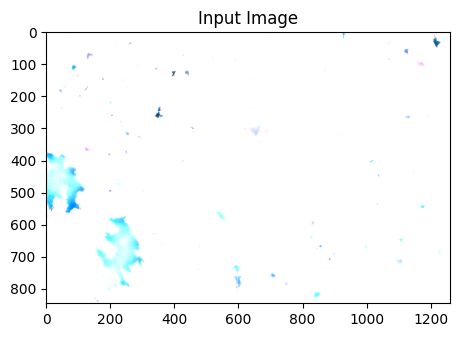

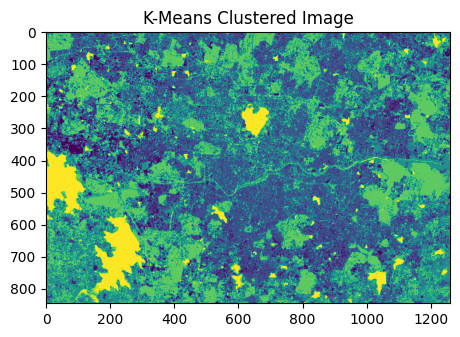

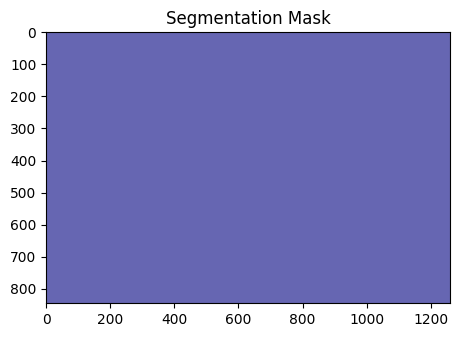

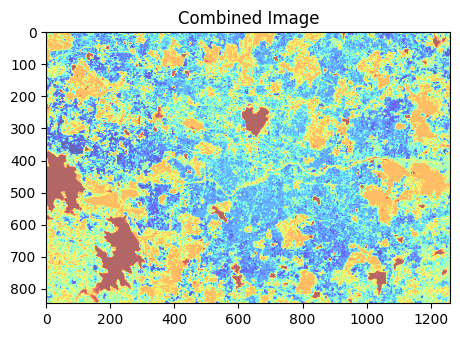

In [3]:
# Display the input image, k-means clustered image, segmentation mask, and the combined image
plt.figure(figsize=(24, 8))

# Input Image
plt.subplot(1, 4, 1)
plt.imshow(rasterio.open(tif_image_path).read([8, 4, 3]).transpose(1, 2, 0))
plt.title("Input Image")

# K-Means Clustered Image
plt.figure(figsize=(24, 8))
plt.subplot(1, 4, 2)
plt.imshow(clustered_image, cmap='viridis')
plt.title("K-Means Clustered Image")

# Segmentation Mask
plt.figure(figsize=(24, 8))
plt.subplot(1, 4, 3)
plt.imshow(output_predictions, cmap='jet', alpha=0.6)
plt.title("Segmentation Mask")

# Combined Image
plt.figure(figsize=(24, 8))
plt.subplot(1, 4, 4)
plt.imshow(combined_image, cmap='jet', alpha=0.6)
plt.title("Combined Image")

plt.show()